# Libraries

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

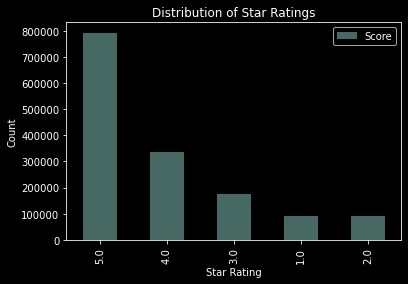


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START
Processing training data...
Processing test data...
Vectorizing text data...
Applying Truncated SVD...
Combining features...
Splitting data into training and validation sets...
Training Random Forest Classifier...
Evaluating model...
Validation Accuracy: 0.5785030269082448


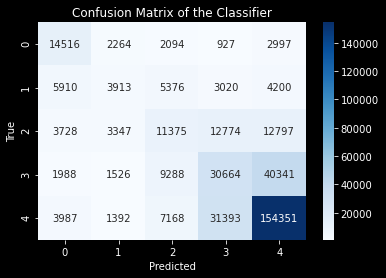

Predicting on test data...
Creating submission file...
Submission file created at './data/submission.csv'


In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import exists
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import os
import warnings
warnings.filterwarnings('ignore')

# Load the datasets
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)
print()
print(trainingSet.head())
print()
print(testingSet.head())
print()
print(trainingSet.describe())

# Plot the distribution of scores
trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()
print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Remove existing feature files if they exist
if exists('./data/X_train.csv'):
    os.remove('./data/X_train.csv')
if exists('./data/X_submission.csv'):
    os.remove('./data/X_submission.csv')

# Define positive and negative word lists
positive_words = ['good', 'great', 'excellent', 'amazing', 'love', 'wonderful', 'best', 'fantastic',
                  'awesome', 'perfect', 'enjoyed', 'favorite', 'liked', 'recommend', 'brilliant',
                  'fun', 'pleasant', 'delightful', 'superb', 'happy', 'satisfied', 'positive',
                  'impressive', 'incredible', 'outstanding', 'spectacular', 'terrific']

negative_words = ['bad', 'terrible', 'awful', 'hate', 'worst', 'boring', 'poor', 'disappointing',
                  'waste', 'dull', 'predictable', 'unfortunately', 'lame', 'annoying', 'mediocre',
                  'hardly', 'problem', 'mess', 'ridiculous', 'uninteresting', 'unhappy', 'unsatisfied',
                  'negative', 'unpleasant', 'horrible', 'dislike', 'frustrating', 'overrated', 'weak']

# Function to add features
def add_features_to(df):
    # Calculate helpfulness ratio
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
    # Fill missing text and summary with empty strings
    df['Text'] = df['Text'].fillna('').astype(str)
    df['Summary'] = df['Summary'].fillna('').astype(str)
    
    # Convert text to lowercase
    df['Text'] = df['Text'].str.lower()
    df['Summary'] = df['Summary'].str.lower()
    
    # Add text length features
    df['Text_length'] = df['Text'].apply(len)
    df['Summary_length'] = df['Summary'].apply(len)
    
    # Add word count features
    df['Text_word_count'] = df['Text'].apply(lambda x: len(x.split()))
    df['Summary_word_count'] = df['Summary'].apply(lambda x: len(x.split()))
    
    # Average word length
    df['Avg_word_length'] = df['Text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
    
    # Unique word count
    df['Unique_word_count'] = df['Text'].apply(lambda x: len(set(x.split())))
    
    # Exclamation and question marks count
    df['Exclamation_count'] = df['Text'].str.count('!')
    df['Question_count'] = df['Text'].str.count(r'\?')
    
    # Uppercase words count
    df['Uppercase_word_count'] = df['Text'].apply(lambda x: sum(1 for word in x.split() if word.isupper()))
    
    # Positive and negative word counts
    df['Positive_word_count'] = df['Text'].apply(
        lambda x: sum(1 for word in positive_words if word in x))
    df['Negative_word_count'] = df['Text'].apply(
        lambda x: sum(1 for word in negative_words if word in x))
    
    return df

# Process the DataFrame
print("Processing training data...")
train = add_features_to(trainingSet)

# Merge on Id to include features in the submission set
print("Processing test data...")
X_submission = pd.merge(train, testingSet, on='Id', how='right')
X_submission = X_submission.drop(columns=['Score_x'])
X_submission = X_submission.rename(columns={'Score_y': 'Score'})

# Training set where the score is not null
X_train = train[train['Score'].notnull()]

# Save the processed data for future use
X_submission.to_csv("./data/X_submission.csv", index=False)
X_train.to_csv("./data/X_train.csv", index=False)

# Feature Selection
features = [
    'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness',
    'Text_length', 'Summary_length', 'Text_word_count', 'Summary_word_count',
    'Avg_word_length', 'Unique_word_count', 'Exclamation_count', 'Question_count',
    'Uppercase_word_count', 'Positive_word_count', 'Negative_word_count'
]

X_train_features = X_train[features]
X_submission_features = X_submission[features]

# Fill any missing values in features
X_train_features = X_train_features.fillna(0)
X_submission_features = X_submission_features.fillna(0)

# Text Vectorization using TF-IDF with n-grams and stop words removal
print("Vectorizing text data...")
text_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)
text_vectorizer.fit(X_train['Text'])

X_train_text_tfidf = text_vectorizer.transform(X_train['Text'])
X_submission_text_tfidf = text_vectorizer.transform(X_submission['Text'])

# Dimensionality Reduction using Truncated SVD
print("Applying Truncated SVD...")
svd = TruncatedSVD(n_components=100, random_state=42)
svd.fit(X_train_text_tfidf)

X_train_text_svd = svd.transform(X_train_text_tfidf)
X_submission_text_svd = svd.transform(X_submission_text_tfidf)

# Combine numerical features and text features
print("Combining features...")
X_train_num = X_train_features.values
X_submission_num = X_submission_features.values

X_train_final = np.hstack((X_train_num, X_train_text_svd))
X_submission_final = np.hstack((X_submission_num, X_submission_text_svd))

# Target variable
Y_train = X_train['Score'].astype(int)

# Split training set into training and testing set
print("Splitting data into training and validation sets...")
X_train_split, X_valid_split, Y_train_split, Y_valid_split = train_test_split(
    X_train_final, Y_train, test_size=0.25, random_state=42, stratify=Y_train
)

# Model Creation with optimized hyperparameters
print("Training Random Forest Classifier...")
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_split, Y_train_split)

# Model Evaluation
print("Evaluating model...")
Y_valid_pred = model.predict(X_valid_split)
accuracy = accuracy_score(Y_valid_split, Y_valid_pred)
print("Validation Accuracy:", accuracy)

# Plot a confusion matrix
cm = confusion_matrix(Y_valid_split, Y_valid_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of the Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Predict on the test set
print("Predicting on test data...")
Y_submission_pred = model.predict(X_submission_final)

# Create submission file
print("Creating submission file...")
X_submission['Score'] = Y_submission_pred
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

print("Submission file created at './data/submission.csv'")
